# Practical Machine Learning Assignment

### Ehsan Kourkchi

#### May 28, 2019

# Problem Defenition

Data on human activity during workout sessions are acquired using multiple devices attached to human body and dumbbells. The goal is to build a model to predict the quality of performance when using dumbbells. 

More infomation on the provided data is available [Here](http://web.archive.org/web/20161224072740/http:/groupware.les.inf.puc-rio.br/har).

Wearable devices provide inforamtion on the movements and accelaration of waist, wrist, forearm and dumbbell. The quality of executation is then alphabetically labelled as following 

Class A. exactly according to the specification
Class B. throwing the elbows to the front
Class C. lifting the dumbbell only halfway
Class D. lowering the dumbbell only halfway
Class E. throwing the hips to the front

## Loading data in R

We use R packages ggplot2 for plotting and caret for implementing our model.

In [1]:
library(ggplot2)
library(caret)

## https://d396qusza40orc.cloudfront.net/predmachlearn/pml-training.csv
Training <- read.csv(file="pml-training.csv", header=TRUE, sep=",")

## https://d396qusza40orc.cloudfront.net/predmachlearn/pml-testing.csv
Testing  <- read.csv(file="pml-testing.csv" , header=TRUE, sep=",")

dim(Training)
dim(Testing)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: lattice


[1] 19622   160

[1]  20 160

## Slicing the Training Data

In order to be able to peroform some out-of-training evaluation, we only use 70% of our training data for training our model and leave out the rest for cross validation.

We perform the best model on the Testing data at the end. 

In [2]:
inTrain <- createDataPartition(y=Training$classe, p=0.7, list=FALSE)
training <- Training[inTrain,]
crossvalidation <- Training[-inTrain,]

## Checking out what we've got

A quick investigation using Open Office Excell shows that there are many columns that are either empy or filled with **"NA"** or **#DIV/0!**.

These columns are also missing in the Test data we have laoded. Therefore there is no point to use these columsn for training our model. 
Therefore we refine our data sets to only contain the relevant healthy data points. 

In [19]:
summary(training$classe)

print("Dimension of Training Set: ") ; dim(training)
print("Dimension of Cross Validation Set: ") ; dim(crossvalidation)

all_features = names(training)
for (i in seq_along(all_features)) {
    
    cat(sprintf("Column #%d \t \"%s\"\n", i, all_features[i]))
    
} 

# This shows the data types of different columns and example values of first few rows
str(training)

A    B    C    D    E 
3906 2658 2396 2252 2525

[1] "Dimension of Training Set: "


[1] 13737   160

[1] "Dimension of Cross Validation Set: "


[1] 5885  160

Column #1 	 "X"
Column #2 	 "user_name"
Column #3 	 "raw_timestamp_part_1"
Column #4 	 "raw_timestamp_part_2"
Column #5 	 "cvtd_timestamp"
Column #6 	 "new_window"
Column #7 	 "num_window"
Column #8 	 "roll_belt"
Column #9 	 "pitch_belt"
Column #10 	 "yaw_belt"
Column #11 	 "total_accel_belt"
Column #12 	 "kurtosis_roll_belt"
Column #13 	 "kurtosis_picth_belt"
Column #14 	 "kurtosis_yaw_belt"
Column #15 	 "skewness_roll_belt"
Column #16 	 "skewness_roll_belt.1"
Column #17 	 "skewness_yaw_belt"
Column #18 	 "max_roll_belt"
Column #19 	 "max_picth_belt"
Column #20 	 "max_yaw_belt"
Column #21 	 "min_roll_belt"
Column #22 	 "min_pitch_belt"
Column #23 	 "min_yaw_belt"
Column #24 	 "amplitude_roll_belt"
Column #25 	 "amplitude_pitch_belt"
Column #26 	 "amplitude_yaw_belt"
Column #27 	 "var_total_accel_belt"
Column #28 	 "avg_roll_belt"
Column #29 	 "stddev_roll_belt"
Column #30 	 "var_roll_belt"
Column #31 	 "avg_pitch_belt"
Column #32 	 "stddev_pitch_belt"
Column #33 	 "var_pitch_belt"
Col

In [4]:
### This feature is not useful, because in most cases it is either blank or equals #DIV/0!
summary(training$kurtosis_yaw_belt)

#DIV/0! 
  13461     276

In [5]:
#  These are the columns (fetures) with useful data. We only use these columns for our work here.

#                 "roll_belt","pitch_belt","yaw_belt","total_accel_belt",
#                 "gyros_belt_x","gyros_belt_y","gyros_belt_z",
#                 "accel_belt_x","accel_belt_y","accel_belt_z",
#                 "magnet_belt_x","magnet_belt_y","magnet_belt_z",
#                 "roll_arm","pitch_arm","yaw_arm","total_accel_arm",
#                 "gyros_arm_x","gyros_arm_y","gyros_arm_z",
#                 "accel_arm_x","accel_arm_y","accel_arm_z",
#                 "magnet_arm_x","magnet_arm_y","magnet_arm_z",
#                 "roll_dumbbell","pitch_dumbbell","yaw_dumbbell","total_accel_dumbbell",
#                 "gyros_dumbbell_x","gyros_dumbbell_y","gyros_dumbbell_z",
#                 "accel_dumbbell_x","accel_dumbbell_y","accel_dumbbell_z",
#                 "magnet_dumbbell_x","magnet_dumbbell_x","magnet_dumbbell_z",
#                 "roll_forearm","pitch_forearm","yaw_forearm","total_accel_forearm",
#                 "gyros_forearm_x","gyros_forearm_y","gyros_forearm_z",
#                 "accel_forearm_x","accel_forearm_y","accel_forearm_z",
#                 "magnet_forearm_x","magnet_forearm_y","magnet_forearm_z"

## Make some quick observations

Below, I have plotted "roll_belt" versus "pitch_belt" parameters, and colored points by their class. As seen in some cases only these two parameters are enought to make accurate predictions. For example, if there exists a point with pitch_belt>15 and roll_belt<25, it 100% belongs to class "E" with no confusion. 

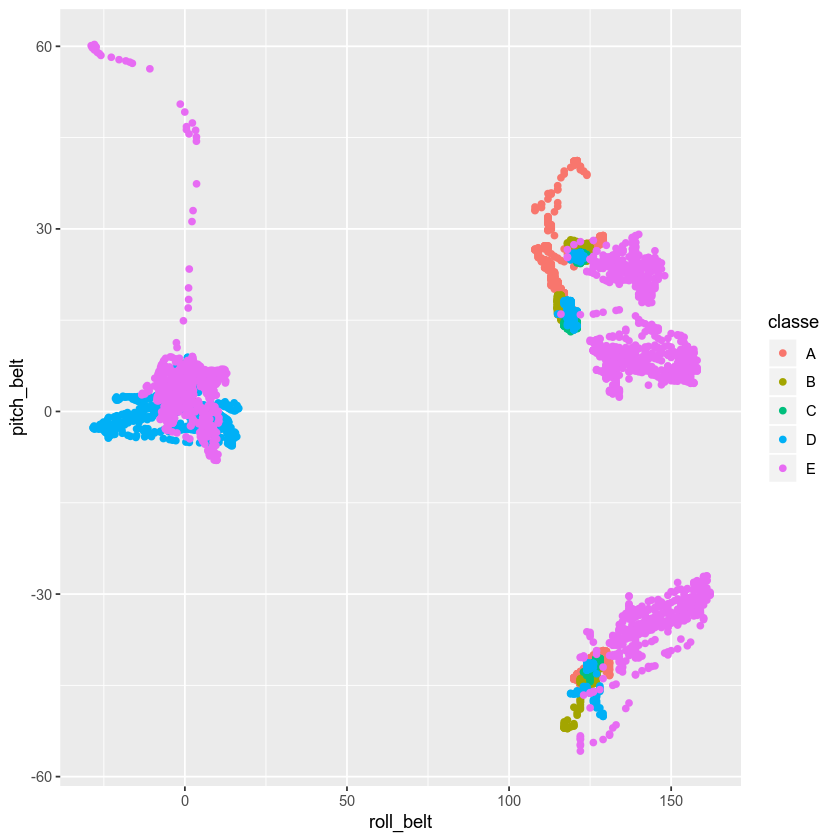

In [6]:
qplot(roll_belt, pitch_belt, color=classe, data=training)

## Making more observations 

Making a pair plot for only 4 parameters, we discover that our data points are somehow clusterred in different regions. Although different classes are not completely differntiated in the following plot, it suggests that there might be a chance that by adding more features we would be able to make accurate differentiations. 

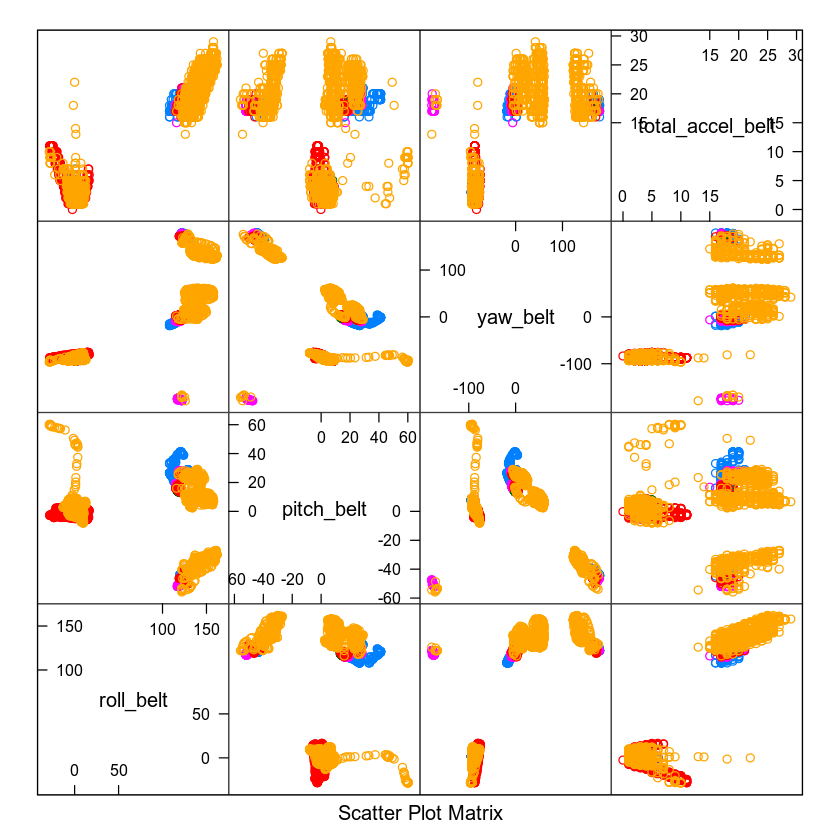

In [7]:
featurePlot(x=training[,c("roll_belt","pitch_belt","yaw_belt", "total_accel_belt")],
            y = training$classe,
            plot="pairs")

## Using Random Forest for prediction

In the following cell, we perform a random forest analysis to get our model. To begin with, we only use those parameters that are related to "belt" and ignore the otehrs to see if we are able to make good predictions.

To get better results, we do some standarization preprocessing. We also control our training process by setting trControl parameter. This allows the training algrotihm to set away 30% of the given training data for cross validation and tunes the internal parameters to reach the best accuracy after 5 iterations. 

In [8]:
set.seed(125)

RFmodel <- train(classe ~ roll_belt+pitch_belt+yaw_belt+total_accel_belt+
                gyros_belt_x+gyros_belt_y+gyros_belt_z+
                accel_belt_x+accel_belt_y+accel_belt_z+
                magnet_belt_x+magnet_belt_y+magnet_belt_z, 
                data = training, 
                method = "rf", 
                metric = "Accuracy", 
                preProcess = c("center", "scale"), 
                trControl = trainControl(method = "cv", 
                                       number = 5,           
                                       p = 0.7, 
                                       allowParallel = TRUE),                                       
                prox = TRUE)

## Checking the trained RF model for the trainign set

Here we use the resulting random forest to make predictions on the training set. As seen the accuracy is 100%, which means our model totally follows the shape of our data. We don't expect to get the same accuracy for the cross validation set.

In [9]:
rf.result.training <- predict(RFmodel, training)
confusionMatrix(training$classe, rf.result.training)

Confusion Matrix and Statistics

          Reference
Prediction    A    B    C    D    E
         A 3906    0    0    0    0
         B    0 2658    0    0    0
         C    0    0 2396    0    0
         D    0    0    0 2252    0
         E    0    0    0    0 2525

Overall Statistics
                                     
               Accuracy : 1          
                 95% CI : (0.9997, 1)
    No Information Rate : 0.2843     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         

Statistics by Class:

                     Class: A Class: B Class: C Class: D Class: E
Sensitivity            1.0000   1.0000   1.0000   1.0000   1.0000
Specificity            1.0000   1.0000   1.0000   1.0000   1.0000
Pos Pred Value         1.0000   1.0000   1.0000   1.0000   1.0000
Neg Pred Value         1.0000   1.0000   1.0000   1.0000   1.0000
Prevalence      

## Evaluating the trained RF model for the Cross Validation Set
### Out-of-sample error

As expected the performance of our model is worse (~92%) on the cross validation set. Our model has been overfitted on the training set and explain the training set very well, while its accuracy is worse when we consider a cross validation set.

In addition, 92% is still a good accuracy. This means that only using the data from the belt sensors would be enough to get good predictions. 

In [10]:
rf.result <- predict(RFmodel, crossvalidation)
confusionMatrix(crossvalidation$classe, rf.result)

Confusion Matrix and Statistics

          Reference
Prediction    A    B    C    D    E
         A 1545   27   53   42    7
         B   34 1042   43   17    3
         C   44   53  887   41    1
         D   50    5   32  872    5
         E   16    2    6    4 1054

Overall Statistics
                                          
               Accuracy : 0.9176          
                 95% CI : (0.9103, 0.9245)
    No Information Rate : 0.287           
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.8957          
                                          
 Mcnemar's Test P-Value : 0.04805         

Statistics by Class:

                     Class: A Class: B Class: C Class: D Class: E
Sensitivity            0.9147   0.9229   0.8688   0.8934   0.9850
Specificity            0.9693   0.9796   0.9714   0.9813   0.9942
Pos Pred Value         0.9229   0.9148   0.8645   0.9046   0.9741
Neg Pred Value         0.9658   0.981

## Make predictions using the Test set

The followig cell takes the test set and uses the same trained RF model to predict the class of each row. 

In [11]:
rf.result.Testing <- predict(RFmodel, Testing)
for (i in Testing$problem_id) {
cat(sprintf("Quiz #%d \t \"%s\"\n", Testing$problem_id[i], rf.result.Testing[i]))
}

Quiz #1 	 "B"
Quiz #2 	 "A"
Quiz #3 	 "B"
Quiz #4 	 "A"
Quiz #5 	 "A"
Quiz #6 	 "E"
Quiz #7 	 "D"
Quiz #8 	 "B"
Quiz #9 	 "A"
Quiz #10 	 "A"
Quiz #11 	 "B"
Quiz #12 	 "C"
Quiz #13 	 "B"
Quiz #14 	 "A"
Quiz #15 	 "E"
Quiz #16 	 "E"
Quiz #17 	 "A"
Quiz #18 	 "B"
Quiz #19 	 "B"
Quiz #20 	 "B"


## Training a more complicated Random Forest using all data features

To even get better results, we train a more complex random forest model that uses all data columns. This part take more computation resources.

In [12]:
set.seed(125)

RFmodel.all <- train(classe ~ new_window+num_window+ 
                roll_belt+pitch_belt+yaw_belt+total_accel_belt+
                gyros_belt_x+gyros_belt_y+gyros_belt_z+
                accel_belt_x+accel_belt_y+accel_belt_z+
                magnet_belt_x+magnet_belt_y+magnet_belt_z+
                roll_arm+pitch_arm+yaw_arm+total_accel_arm+
                gyros_arm_x+gyros_arm_y+gyros_arm_z+
                accel_arm_x+accel_arm_y+accel_arm_z+
                magnet_arm_x+magnet_arm_y+magnet_arm_z+
                roll_dumbbell+pitch_dumbbell+yaw_dumbbell+total_accel_dumbbell+
                gyros_dumbbell_x+gyros_dumbbell_y+gyros_dumbbell_z+
                accel_dumbbell_x+accel_dumbbell_y+accel_dumbbell_z+
                magnet_dumbbell_x+magnet_dumbbell_x+magnet_dumbbell_z+
                roll_forearm+pitch_forearm+yaw_forearm+total_accel_forearm+
                gyros_forearm_x+gyros_forearm_y+gyros_forearm_z+
                accel_forearm_x+accel_forearm_y+accel_forearm_z+
                magnet_forearm_x+magnet_forearm_y+magnet_forearm_z, 
                data = training, 
                method = "rf", 
                metric = "Accuracy", 
                preProcess = c("center", "scale"), 
                trControl = trainControl(method = "cv", 
                                       number = 5,           
                                       p = 0.7, 
                                       allowParallel = TRUE),                                       
                prox = TRUE)

## Evaluating the perforamnce of the RF-all on the training set

Like the other model, the accuracy is 100%. Now the question is whether we get better results on the cross validation set.

In [14]:
rf.result.training <- predict(RFmodel.all, training)
confusionMatrix(training$classe, rf.result.training)

Confusion Matrix and Statistics

          Reference
Prediction    A    B    C    D    E
         A 3906    0    0    0    0
         B    0 2658    0    0    0
         C    0    0 2396    0    0
         D    0    0    0 2252    0
         E    0    0    0    0 2525

Overall Statistics
                                     
               Accuracy : 1          
                 95% CI : (0.9997, 1)
    No Information Rate : 0.2843     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         

Statistics by Class:

                     Class: A Class: B Class: C Class: D Class: E
Sensitivity            1.0000   1.0000   1.0000   1.0000   1.0000
Specificity            1.0000   1.0000   1.0000   1.0000   1.0000
Pos Pred Value         1.0000   1.0000   1.0000   1.0000   1.0000
Neg Pred Value         1.0000   1.0000   1.0000   1.0000   1.0000
Prevalence      

## Evaluating RFmodel.all on the cross-validation set

This time, the accouracy is ~99.9% which is of course better than 98% we got using the our first Random Forest model. Our conclusion is that adding more features definitely improves our prediction accuracy. 

This means that for improving accuracy by 7%, we needed to use all ifnroamtion from all sensors. 
Sometimes adding more sensors is expensive and is not worth the few percent improvment in predictions.

At this point, our model make very good predictions. We performed our training only on the trainign set and only used the cross validation set for evaluating our final model.

In [15]:
rf.result.all <- predict(RFmodel.all, crossvalidation)
confusionMatrix(crossvalidation$classe, rf.result.all)

Confusion Matrix and Statistics

          Reference
Prediction    A    B    C    D    E
         A 1674    0    0    0    0
         B    0 1139    0    0    0
         C    0    1 1025    0    0
         D    0    0    2  961    1
         E    0    0    0    2 1080

Overall Statistics
                                          
               Accuracy : 0.999           
                 95% CI : (0.9978, 0.9996)
    No Information Rate : 0.2845          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9987          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: A Class: B Class: C Class: D Class: E
Sensitivity            1.0000   0.9991   0.9981   0.9979   0.9991
Specificity            1.0000   1.0000   0.9998   0.9994   0.9996
Pos Pred Value         1.0000   1.0000   0.9990   0.9969   0.9982
Neg Pred Value         1.0000   0.999

## Using RFmodel.all to make predictions on the Test set

In [17]:
rf.result.Testing <- predict(RFmodel.all, Testing)
for (i in Testing$problem_id) {
cat(sprintf("Quiz #%d \t \"%s\"\n", Testing$problem_id[i], rf.result.Testing[i]))
}

Quiz #1 	 "B"
Quiz #2 	 "A"
Quiz #3 	 "B"
Quiz #4 	 "A"
Quiz #5 	 "A"
Quiz #6 	 "E"
Quiz #7 	 "D"
Quiz #8 	 "B"
Quiz #9 	 "A"
Quiz #10 	 "A"
Quiz #11 	 "B"
Quiz #12 	 "C"
Quiz #13 	 "B"
Quiz #14 	 "A"
Quiz #15 	 "E"
Quiz #16 	 "E"
Quiz #17 	 "A"
Quiz #18 	 "B"
Quiz #19 	 "B"
Quiz #20 	 "B"
